# CODE QUI DOIT FONCTIONNER

In [1]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dossier = '../data/archive/result'
hierarchical_topics = pd.read_csv(f"{dossier}/database_hierarchical_topics.csv",sep=',',encoding='utf8')
news_data = pd.read_csv(f"{dossier}/database_update.csv",sep=',',encoding='utf8')
all_topic = pd.read_csv(f"{dossier}/all_topics.csv",sep=',',encoding='utf8').iloc[1:].reset_index(drop=True)

### Pyvis

In [23]:
news_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", select_menu=True, layout=True)    
news_net.barnes_hut()
max_original_topic = hierarchical_topics.Parent_ID.astype(int).min() - 1

        # Extract mapping from ID to name
topic_to_name = dict(zip(hierarchical_topics.Child_Left_ID, hierarchical_topics.Child_Left_Name))
topic_to_name.update(dict(zip(hierarchical_topics.Child_Right_ID, hierarchical_topics.Child_Right_Name)))
topic_to_name.update(dict(zip(hierarchical_topics.Parent_ID, hierarchical_topics.Parent_Name)))

topic_to_name = {topic: name for topic, name in topic_to_name.items()}
#print((topic_to_name))
        # Create tree
tree = {row[1].Parent_ID: [row[1].Child_Left_ID, row[1].Child_Right_ID]
        for row in hierarchical_topics.iterrows()}


for parent,childs in tree.items():
        src = parent
        src_names = topic_to_name[parent]
        topic_str, distance = hierarchical_topics.loc[hierarchical_topics['Parent_ID'] == parent, ['Topics', 'Distance']].values[0]
        topics = set(int(topic.strip()) for topic in topic_str.strip('[]').split(','))
        news_net.add_node(src, src_names, title=src,size=len(topics))
        for child in childs:
                dst = child
                dst_names = topic_to_name[child]
                news_net.add_node(dst, dst_names, title=dst)
                news_net.add_edge(src, dst,values=distance)
           

for index, row in all_topic.iterrows():
        last_parent_id = None
        matching_rows = hierarchical_topics[hierarchical_topics['Topics'].apply(lambda x: row['Topic'] in list(int(topic.strip()) for topic in x.strip('[]').split(',')))]
        if not matching_rows.empty:
                last_parent_id = matching_rows['Parent_ID'].iloc[-1]
        #last_parent_ids[str(row['Topic'])]= last_parent_id
        Child_ID = hierarchical_topics.loc[hierarchical_topics['Parent_ID'] == last_parent_id,['Child_Left_ID','Child_Right_ID']].values[0]
        #print(parent,Child_Left_ID,Child_Right_ID)
        if row['Topic'] not in Child_ID:
                news_net.add_node(row['Topic'], row['Name'], title=row['Topic'])
                news_net.add_edge(last_parent_id, row['Topic'])

                
for index,row in news_data.iterrows():
        if int(row['topic']) != -1 :
                news_net.add_node(row['id'],row['title'],title=row['id'])
                news_net.add_edge(row['topic'],row['id'])
        
        
neighbor_map = news_net.get_adj_list()
for node in news_net.nodes:
# Assurez-vous que node["title"] est une chaîne de caractères
        node_title_str = node["label"]
        neighbors_str = ", ".join(str(neighbor) for neighbor in neighbor_map[node["id"]])
        # Utilisez la version chaîne de caractères de node["title"] pour la concaténation
        node["title"] = node_title_str + "\n Neighbors : [" + neighbors_str + "]"
        node["value"] = len(neighbor_map[node["id"]])


news_net.toggle_physics(True)
news_net.show_buttons(True)
news_net.inherit_edge_colors(True)
news_net.save_graph("graphs_.html")   


In [3]:
from matplotlib.colors import ListedColormap

noms_uniques = news_data['publication'].unique()
cmap_complete = plt.cm.tab20
colors = cmap_complete.colors[:len(noms_uniques)]

cmap_custom = ListedColormap(colors)
couleur_par_journal = {journal: cmap_custom.colors[i] for i, journal in enumerate(noms_uniques)}
news_data['Couleur'] = news_data['publication'].map(couleur_par_journal)


### Networkx --> Pyvis

In [4]:
news_net = nx.Graph()   
max_original_topic = hierarchical_topics.Parent_ID.astype(int).min() - 1

topic_to_name = dict(zip(hierarchical_topics.Child_Left_ID, hierarchical_topics.Child_Left_Name))
topic_to_name.update(dict(zip(hierarchical_topics.Child_Right_ID, hierarchical_topics.Child_Right_Name)))
topic_to_name.update(dict(zip(hierarchical_topics.Parent_ID, hierarchical_topics.Parent_Name)))

topic_to_name = {topic: name for topic, name in topic_to_name.items()}
tree = {row[1].Parent_ID: [row[1].Child_Left_ID, row[1].Child_Right_ID]
        for row in hierarchical_topics.iterrows()}


for parent,childs in tree.items():
        src = parent
        src_names = topic_to_name[parent]
        topic_str, distance = hierarchical_topics.loc[hierarchical_topics['Parent_ID'] == parent, ['Topics', 'Distance']].values[0]
        topics = set(int(topic.strip()) for topic in topic_str.strip('[]').split(','))
        news_net.add_node(src, name = src_names, title=src,size=len(topics), color='red')
        for child in childs:
                dst = child
                dst_names = topic_to_name[child]
                count = all_topic.loc[all_topic['Topic'] == child, ['Count']].values
                if len(count) ==0 :
                        news_net.add_node(dst, name = dst_names, title=dst, size = 1, color='blue')
                else : 
                        news_net.add_node(dst, name = dst_names, title=dst, size = int(count[0][0]), color='blue')
                news_net.add_edge(src, dst) 
           
number_of_topic = len(news_net.nodes)
"""for index, row in all_topic.iterrows():
        last_parent_id = None
        matching_rows = hierarchical_topics[hierarchical_topics['Topics'].apply(lambda x: row['Topic'] in list(int(topic.strip()) for topic in x.strip('[]').split(',')))]
        #print(matching_rows)
        if not matching_rows.empty:
                last_parent_id = matching_rows['Parent_ID'].iloc[-1]
        Child_ID = hierarchical_topics.loc[hierarchical_topics['Parent_ID'] == last_parent_id,['Child_Left_ID','Child_Right_ID']].values[0]
        #print(f"Row : {row['Topic']} \n Child : {Child_ID}")
        if row['Topic'] not in Child_ID:
                news_net.add_node(row['Topic'], name = row['Name'], title=row['Topic'], size = 1000,color='black')
                news_net.add_edge(last_parent_id, row['Topic'])
"""
        
for index,row in news_data.iterrows():
        if int(row['topic']) != -1 :
                news_net.add_node(row['id'],name=row['title'],title=row['id'], size = 1, color=row['Couleur'])
                news_net.add_edge(row['topic'],row['id'])



In [11]:
import pickle
import json

#nx.write_graphml_lxml(news_net, "news_net.graphml")
pos = nx.spring_layout(news_net, iterations=15, dim=2)

with open('positions.pickle', 'wb') as f:
    pickle.dump(pos, f)

graph_json = nx.node_link_data(news_net) 

with open("mon_graphe.json", "w") as f:
    json.dump(graph_json, f)


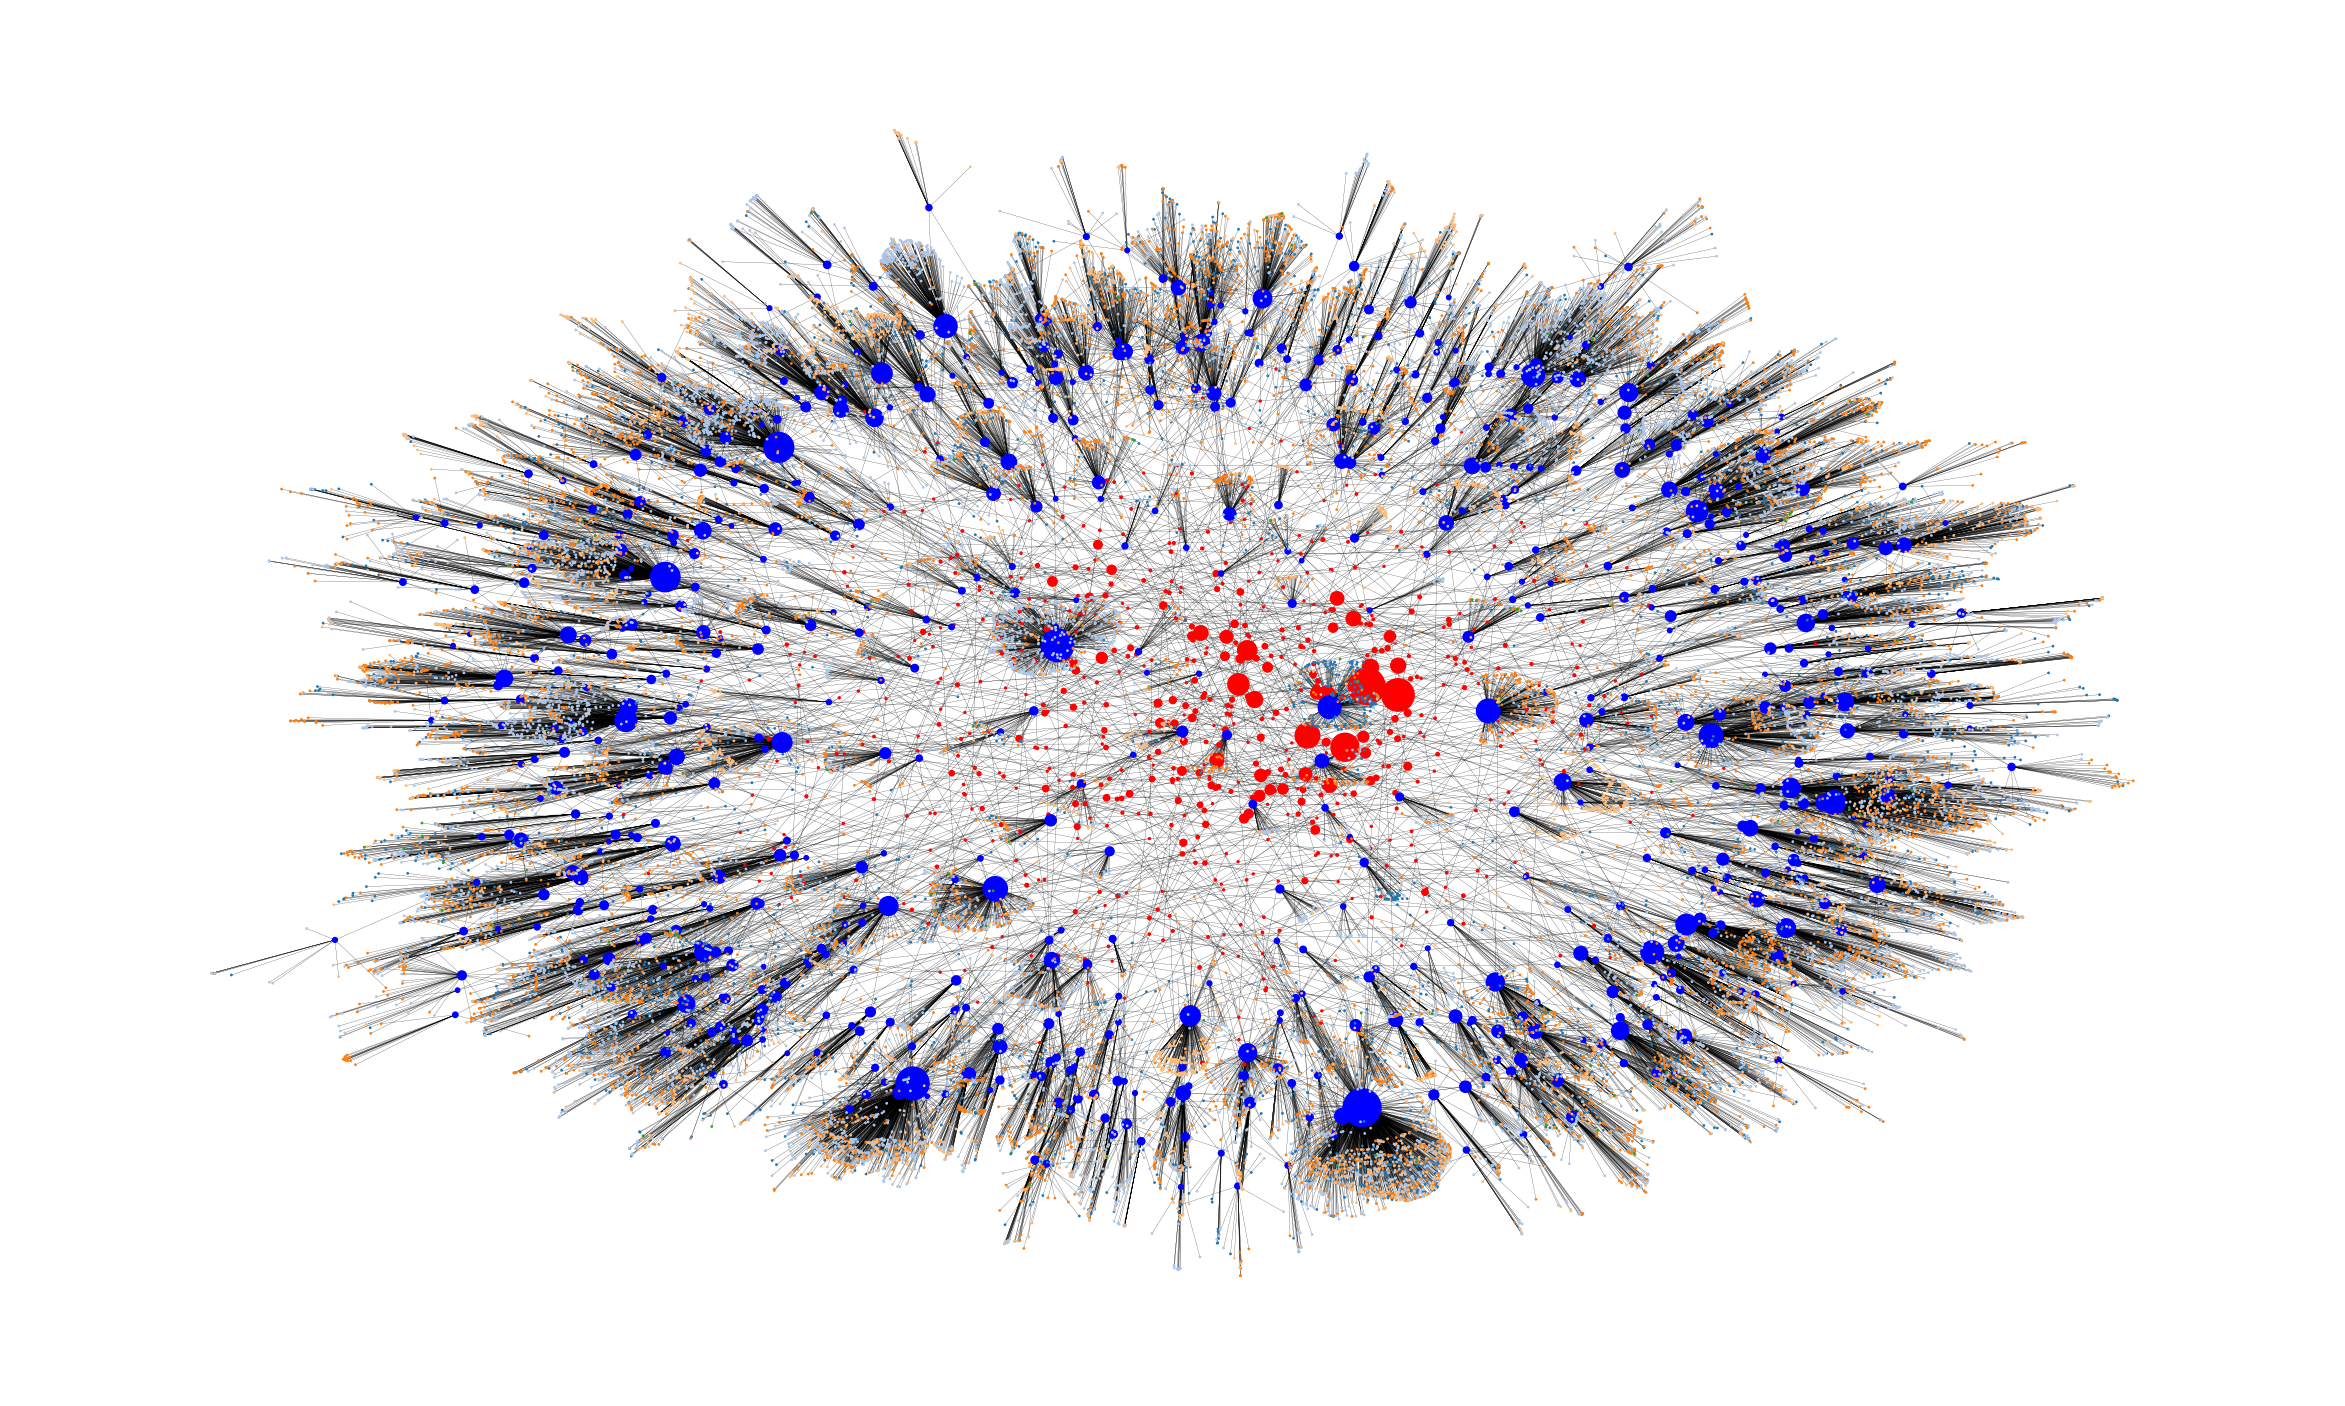

In [12]:
fig, ax = plt.subplots(figsize=(30, 18))
ax.axis("off")
plot_options = { "with_labels": False, "width": 0.15}
colors = [news_net.nodes[n]['color'] for n in news_net.nodes]
sizes = [news_net.nodes[n]['size'] for n in news_net.nodes]
nx.draw_networkx(news_net, node_size=sizes, node_color=colors,pos=pos, ax=ax, **plot_options)
plt.show()

Convectir vers Pyvis :

In [13]:
news_net_pyvis = Network(height="750px", width="100%", bgcolor="white", font_color="white", select_menu=True, layout=True)
news_net_pyvis.from_nx(news_net)
news_net_pyvis.toggle_physics(True)
news_net_pyvis.show_buttons(True)
news_net_pyvis.save_graph("graphs_NX.html") 

### Analysis : 

Need to be improve

## Community 

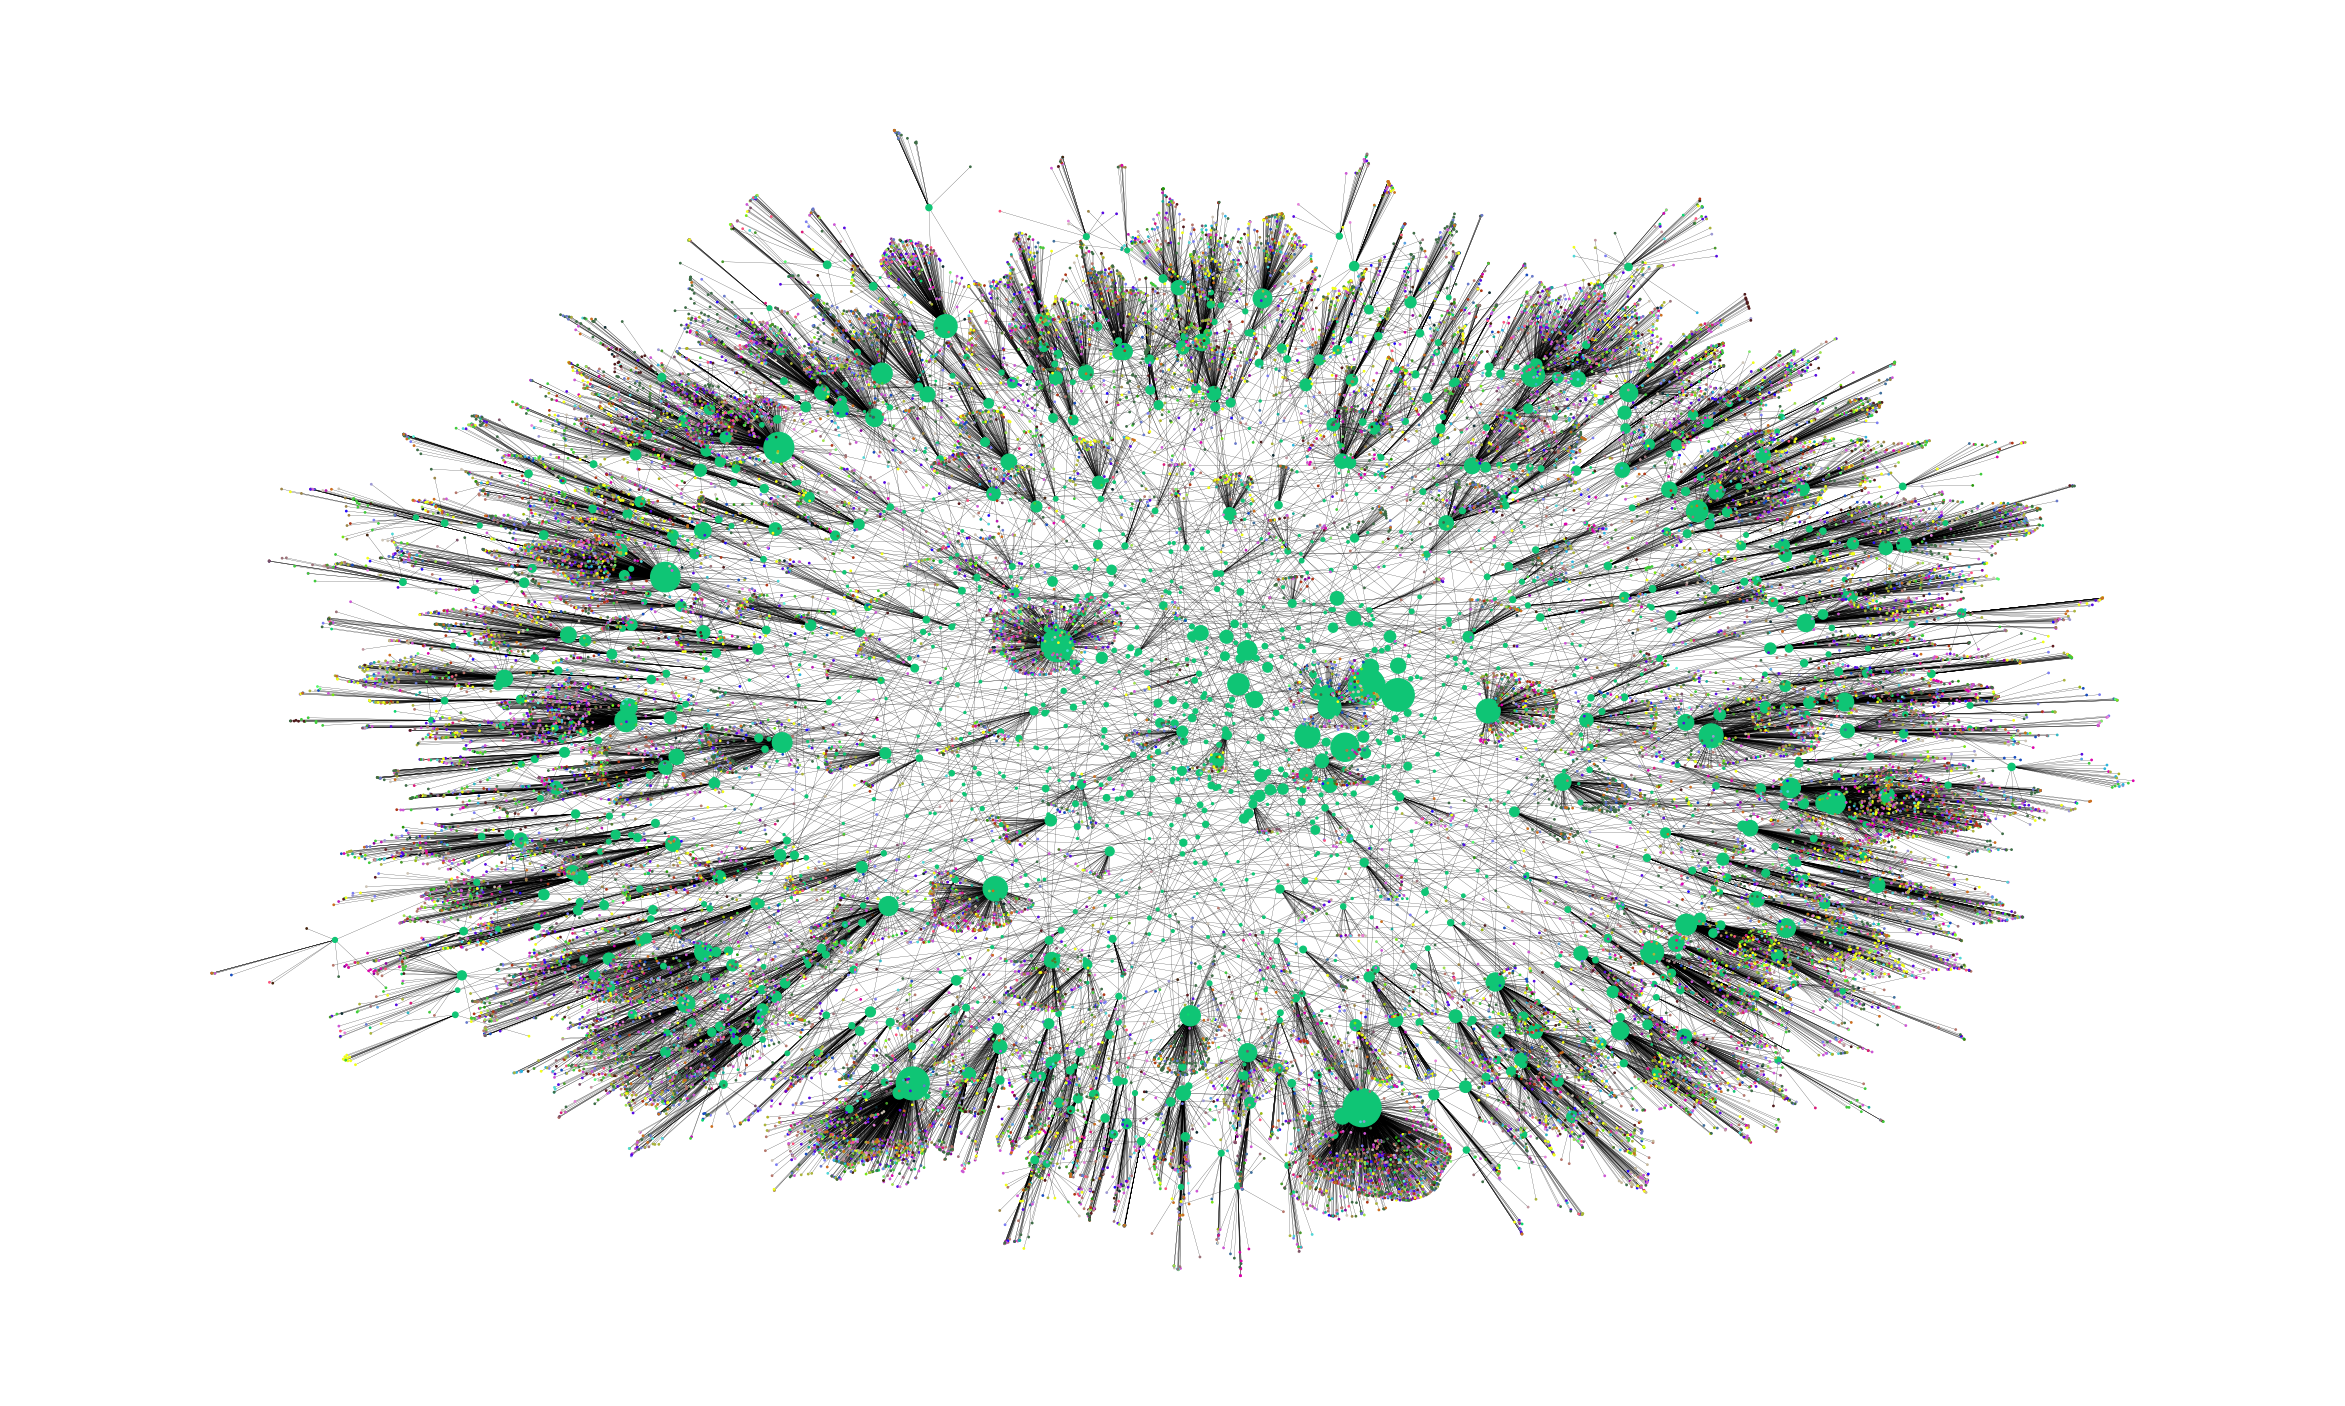

In [38]:
colors = {}
for com in nx.community.asyn_fluidc(news_net, 50, seed=0):
    color = "#%06X" % np.random.randint(0, 0xFFFFFF)
    for node in list(com):
        #print(node,color,len(colors), colors)
        colors[node] = color



fig, ax = plt.subplots(figsize=(30, 18))
ax.axis("off")
plot_options = { "with_labels": False, "width": 0.15}
sizes = [news_net.nodes[n]['size'] for n in news_net.nodes]
nx.draw_networkx(news_net, node_size=sizes, node_color=list(colors.values()),pos=pos, ax=ax, **plot_options)
plt.show()